In [1]:
from disk_utils_jax import jax_model
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np
from interpolated_univariate_spline import InterpolatedUnivariateSpline

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
# Spline parameters

KNOTS = 10

spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}

# Initial guess
init_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
x = np.cos(np.linspace(0, np.pi, KNOTS))
y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)
spline_model = InterpolatedUnivariateSpline(x, y)

# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params = disk_params1, spf_params = y)
end = datetime.now()
time1 = end-start
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params1, spf_params = spf_params)
end = datetime.now()
print(end-start)

0:00:07.126399
0:00:03.778929


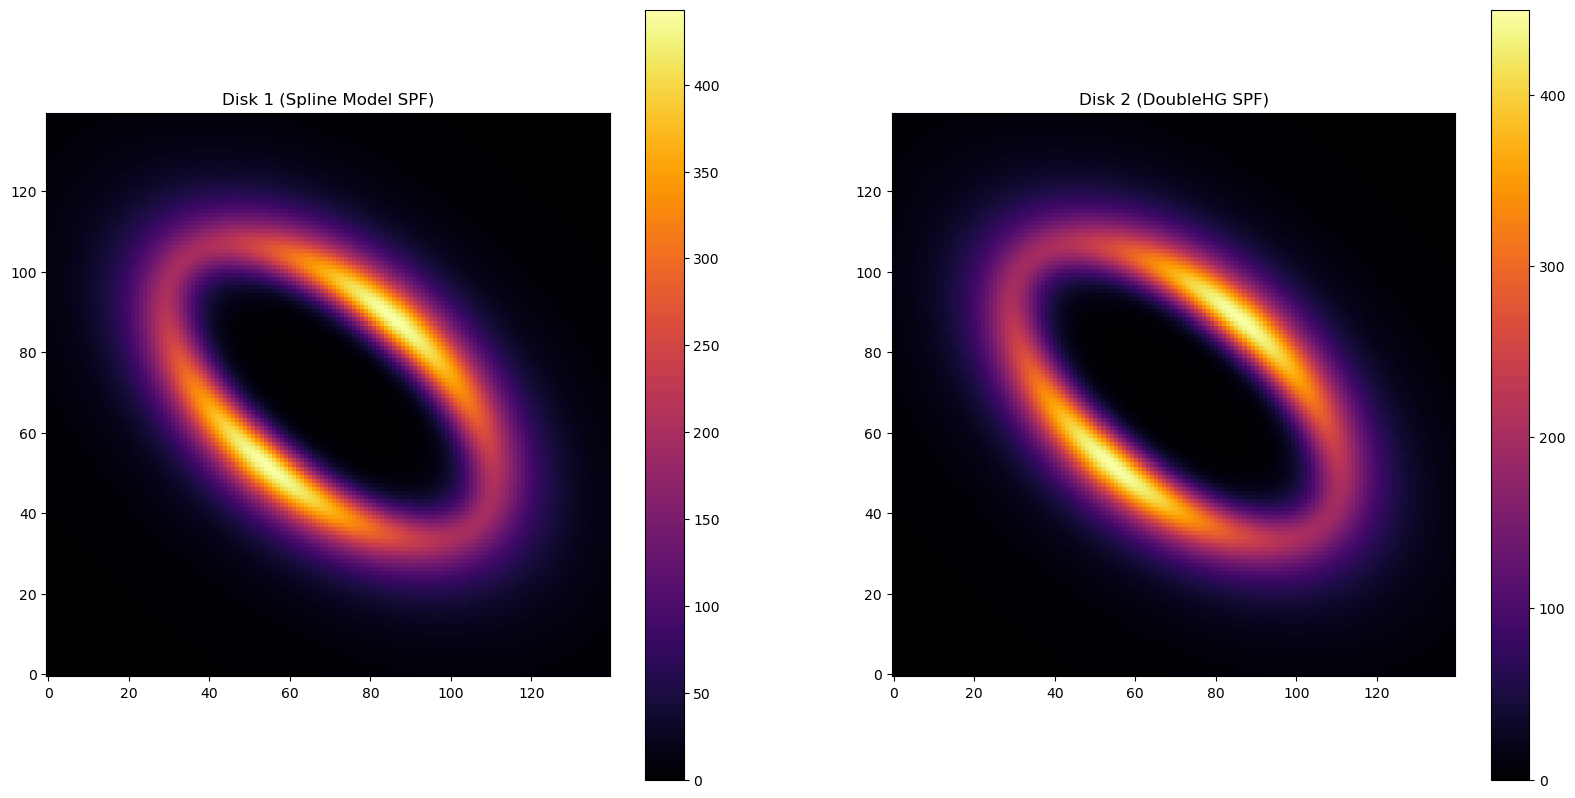

In [4]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Spline Model SPF)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (DoubleHG SPF)")
plt.colorbar(im,ax=axes[1])

In [5]:
jax_model_spline(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params = disk_params1, spf_params = y)

In [8]:
def test_spline_function():
    jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedSpline_SPF, disk_params = disk_params1, spf_params = y)

def test_DHG_function():
    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params1, spf_params = spf_params)

In [9]:
%timeit test_spline_function()
%timeit test_spline_exc_function()
%timeit test_DHG_function()

2.48 ms ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.48 ms ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
140 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
def test():
    return InterpolatedSpline_SPF.pack_pars(y)

def test2():
    return DoubleHenyeyGreenstein_SPF.pack_pars(spf_params)

sm = test()

def test3(x):
    return InterpolatedSpline_SPF.compute_phase_function_from_cosphi(sm, x)

params = test2()

def test4(x):
    return DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(params, x)

In [27]:
%timeit test()
%timeit test2()
%timeit test3(0.1)
%timeit test4(0.1)

69.4 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
26.4 µs ± 771 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
59.4 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
15.3 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
